In [1]:
import sys
sys.path.append("../src")

import numpy as np
import matplotlib.pyplot as plt

from SensorTasking import KalmanFilter, Dynamics
from data_util.cr3bp import cr3bp, jac_cr3bp

In [2]:
mu = 1.215058560962404e-02
x0 = np.array([1.1540242813087864,
        -2.4170502654082446e-28,
        -0.1384196144071876,
        4.06530060663289e-15,
        -0.21493019200956867,
        8.48098638414804e-15])

# x0 = np.array([
#         0.8027692908754149,
#         0.0,
#         0.0,
#         -1.1309830924549648e-14,
#         0.33765564334938736,
#         0.0
#     ])
P0 = 0.0001*np.eye(6)

timestep = 0.015


In [3]:
my_filter = KalmanFilter(timestep=timestep, xof=x0, Pof=P0, func=cr3bp, jac=jac_cr3bp, f_params =(mu,), jac_params=(mu,))
truth = Dynamics(x0=x0, tstep=timestep, f=cr3bp, jac=jac_cr3bp, f_params=[mu], jac_params=[mu])

In [4]:
def some_function(truth, num_observers = 3):

    if num_observers == 0:
        Z, R_invs = (None, None)
    
    else:

        dim = truth.shape[0]

        R_invs = np.zeros(shape=(dim, dim, num_observers))
        Z = np.zeros(shape=(dim, num_observers))

        for i in range(3):
            R_invs[i, i, :] = 1/(0.001**2)   # positional uncertaintiy of +- 384 km (VERY CONSERVATIVE, most sensor can do better)
            R_invs[3 + i, 3 + i, :] = 1/(0.01**2) # velocity uncertainty ~ +- 0.01 km/s

        Z_transpose = np.array([truth.x + np.random.multivariate_normal(mean=np.zeros(dim), cov=np.linalg.inv(R_invs[:,:,j])) for j in range(num_observers)])
        Z = Z_transpose.T

    return Z, R_invs

In [5]:
my_filter.reset()
truth.reset()
steps_=800
state_history = np.zeros(shape=(6, steps_))
tr_cov_history = np.zeros(steps_)
true_history = np.zeros_like(state_history)

for i in range(steps_):
    
    # if np.trace(my_filter.P) >= 0.01: # if uncertainty exceeds ball of radius ~ 384 km ... need measurement
    #     Z, R_invs = some_function(truth, num_observers=1)
    # else:
    #     Z, R_invs = (None, None)
    Z, R_invs = some_function(truth, num_observers=1)
    # Z, R_invs = (None, None)

    my_filter.propagate(Z, R_invs)
    
    truth.propagate(steps=1)

    state_history[:,i] = my_filter.x
    tr_cov_history[i] = np.trace(my_filter.P)
    true_history[:,i] = truth.x

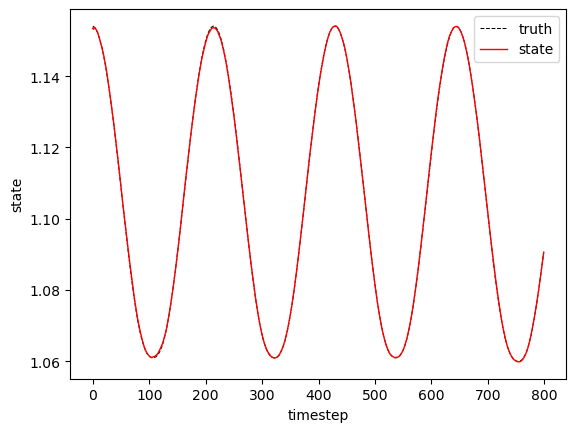

In [6]:
plt.figure()
plt.plot(np.arange(0, true_history.shape[1]), true_history[0,:], linewidth=0.75, color="black", linestyle = "--", label = "truth")
plt.plot(np.arange(0, state_history.shape[1]), state_history[0,:], linewidth=1, color="red", label="state")
plt.xlabel("timestep")
plt.ylabel("state")
plt.legend()
plt.show()

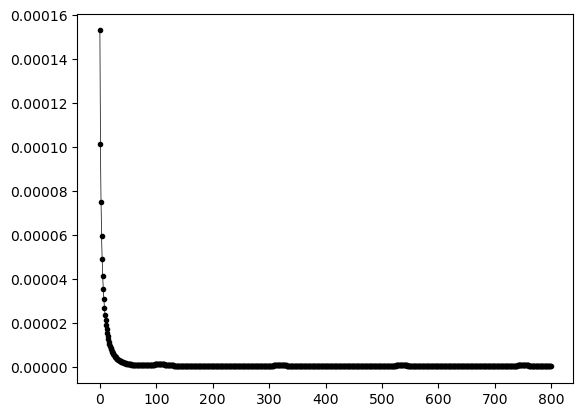

In [7]:
plt.figure()
plt.plot(np.arange(0, tr_cov_history.size), tr_cov_history, marker='.', color="black", linewidth=0.5)